# Libraries / Settings

#### Libraries

In [6]:
# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Clustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans

# Results
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualizations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from tqdm import tqdm

# Web interface
from urllib.request import urlopen
import json

# Misc
import time
from IPython.display import clear_output
from pygame import mixer

pygame 2.3.0 (SDL 2.24.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

gpu_devices = tf.config.list_physical_devices('GPU')
print("Is GPU available?", len(gpu_devices) > 0)

TensorFlow version: 2.12.0-rc1
Is GPU available? False


### Settings for notebook

In [16]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

# salty_data = 'C:/Users/nuke2/Desktop/Python/Projects/Data/SaltyBetter/salty_data_complete.csv' # Desktop
salty_data = 'C:/Users/Sam/Desktop/Python/Projects/Data/SaltyBetter/salty_data_complete.csv' # Laptop

# SaltyData API
match_url = "https://salty-boy.com/current-match"

# Set test-train split percentages
test_train_split_percentage = 0.2
train_validation_split_percentage = 0.2

# Set notebook seed
notebook_seed = 550

# Load notification sound
mixer.init()
# sound_location = 'C:/Users/nuke2/Desktop/Python/Projects/SaltyBetter/mixkit-gaming-lock-2848.wav' # Desktop
sound_location = r'C:\Users\Sam\Desktop\Python\Projects\SaltyBetter\mixkit-gaming-lock-2848.wav' # Laptop
mixer.music.load(sound_location)

# Data cleaning

#### Read data/drop unnecessary columns

In [17]:
# Read data into df_all
df = pd.read_csv(salty_data, low_memory=False)
df_all = df.copy()

# Drop unnecessary columns
df_all.drop(columns=[
    'name',
#     'id', # Need for fighter clustering
    'prev_tier', # Dropped because duplicates
    'fighter_blue',
    'fighter_red',
    'bet_blue',
    'bet_red',
    'match_id',
    'streak_blue',
    'streak_red',
    'winner',
    'away',
    'name_other',
#     'id_other', # Need for fighter clustering
    'prev_tier_other', # Dropped because duplicates
], inplace=True)

# Print details about df_all
print(f"Num rows where elo != tier elo") 
print(f" -- Home: {sum(df_all.elo != df_all.tier_elo)}")
print(f" -- Other: {sum(df_all.elo_other != df_all.tier_elo_other)}")

df_all.head()

Num rows where elo != tier elo
 -- Home: 91575
 -- Other: 91187


,id,best_streak,elo,tier,tier_elo,average_bet,total_matches,win_rate,match_format,match_tier,winner_binary,id_other,best_streak_other,elo_other,tier_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other
0,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,0.0,803.0,2.0,1338.0,S,1338.0,4979841.32,37.0,0.27
1,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,0.0,884.0,14.0,1544.0,S,1433.0,4989952.13,39.0,0.64
2,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,1.0,6375.0,14.0,1702.0,S,1699.0,18188514.31,42.0,0.79
3,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,1.0,769.0,9.0,1623.0,S,1620.0,8723817.10,50.0,0.70
4,804,5,1560,S,1559,10870713.45,44,0.61,matchmaking,S,0.0,1490.0,6.0,1587.0,S,1586.0,7656194.80,55.0,0.64


#### One-hot encode categorical columns

In [18]:
# define a list of columns to one-hot encode
cols_to_encode = ["tier", "match_format", "match_tier", "tier_other"]

# apply one-hot encoding to the selected columns
df_all = pd.get_dummies(df_all, columns=cols_to_encode)

# Drop extra columns
# df_all.drop(columns=[
#     'tier_X', 
#     'tier_other_X', 
#     'match_format_matchmaking', 
#     'match_tier_X'
# ], inplace=True)

#### Copy df_all for Fighter Clustering

In [19]:
df_all_fighter_clustering = df_all.copy()

#### Test train validation split data

In [20]:
# split the dataframe into training, validation, and testing sets
df_train, df_test = train_test_split(df_all, test_size=test_train_split_percentage, 
                                     random_state=notebook_seed)
df_train, df_val = train_test_split(df_train, test_size=train_validation_split_percentage, 
                                    random_state=notebook_seed)

# Save fighter id's
df_train_ids = df_train[['id', 'id_other']]
df_val_ids = df_val[['id', 'id_other']]
df_test_ids = df_test[['id', 'id_other']]
df_train.drop(columns=['id', 'id_other'], inplace=True)
df_val.drop(columns=['id', 'id_other'], inplace=True)
df_test.drop(columns=['id', 'id_other'], inplace=True)

# Get clustering dataframes
df_train_match_clustering_analysis = df_train.copy()
df_val_match_clustering_analysis = df_val.copy()
df_test_match_clustering_analysis = df_test.copy()

#### Standardize data

In [21]:
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,winner_binary,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
43319,4,1296,1293,5980072.09,46,0.30,0.0,5.0,1396.0,1393.0,4712047.65,46.0,0.39,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
54044,3,1415,1415,3118858.60,20,0.30,1.0,6.0,1525.0,1526.0,5044102.30,23.0,0.57,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
89817,3,1381,1381,3629669.88,25,0.32,1.0,2.0,1393.0,1393.0,5591660.17,23.0,0.30,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
22726,12,1579,1584,7667795.18,28,0.71,0.0,10.0,1526.0,1527.0,6231717.65,34.0,0.62,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
89254,3,1409,1410,6857030.28,18,0.28,1.0,6.0,1572.0,1573.0,6105897.70,30.0,0.67,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [22]:
# fit the scaler on the training data
scaler = MinMaxScaler()
scaler.fit(df_train)

# transform the data
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val), columns=df_val.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

# extract y test train validation sets
y_train = df_train.winner_binary
y_val = df_val.winner_binary
y_test = df_test.winner_binary

# Drop win column from feature dataframes
df_train = df_train.drop(columns=['winner_binary'])
df_val = df_val.drop(columns=['winner_binary'])
df_test = df_test.drop(columns=['winner_binary'])

In [23]:
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
0,0.298246,0.156891,0.154185,0.011125,0.535714,0.30,0.4000,0.306667,0.303254,0.012190,0.529412,0.39,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.289474,0.331378,0.333333,0.005550,0.226190,0.30,0.4125,0.497778,0.500000,0.013160,0.258824,0.57,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.289474,0.281525,0.283407,0.006545,0.285714,0.32,0.3625,0.302222,0.303254,0.014760,0.258824,0.30,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.368421,0.571848,0.581498,0.014413,0.321429,0.71,0.4625,0.499259,0.501479,0.016630,0.388235,0.62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.289474,0.322581,0.325991,0.012833,0.202381,0.28,0.4125,0.567407,0.569527,0.016263,0.341176,0.67,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
print(f"Shape of training df: {df_train.shape}")

Shape of training df: (74681, 29)


#### Select Columns

In [25]:
# machine_learning_columns is a general selection of all columns that can be used for machine learning
machine_learning_columns = [
    # Home fighter
    'best_streak',
    'elo',
    'tier_A',
    'tier_B',
    'tier_P',
    'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
    'tier_other_A',
    'tier_other_B',
    'tier_other_P',
    'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
    'match_format_tournament',
    'match_tier_A',
    'match_tier_B',
    'match_tier_P',
    'match_tier_S',
#     'match_tier_X', # Most common category
]

# Clustering

### Match Clustering

#### K-Means Clustering

In [26]:
# Column selection for match k-means
match_clustering_columns = [
    # Home fighter
    'best_streak',
    'elo',
#     'tier_A',
#     'tier_B',
#     'tier_P',
#     'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
#     'tier_other_A',
#     'tier_other_B',
#     'tier_other_P',
#     'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
#     'match_format_tournament',
#     'match_tier_A',
#     'match_tier_B',
#     'match_tier_P',
#     'match_tier_S',
#     'match_tier_X', # Most common category
]

# Set columns above
df_match_clustering = df_train.copy()
df_match_clustering = df_match_clustering[match_clustering_columns]
df_match_clustering.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other
0,0.298246,0.156891,0.154185,0.011125,0.535714,0.30,0.4000,0.306667,0.303254,0.012190,0.529412,0.39
1,0.289474,0.331378,0.333333,0.005550,0.226190,0.30,0.4125,0.497778,0.500000,0.013160,0.258824,0.57
2,0.289474,0.281525,0.283407,0.006545,0.285714,0.32,0.3625,0.302222,0.303254,0.014760,0.258824,0.30
3,0.368421,0.571848,0.581498,0.014413,0.321429,0.71,0.4625,0.499259,0.501479,0.016630,0.388235,0.62
4,0.289474,0.322581,0.325991,0.012833,0.202381,0.28,0.4125,0.567407,0.569527,0.016263,0.341176,0.67


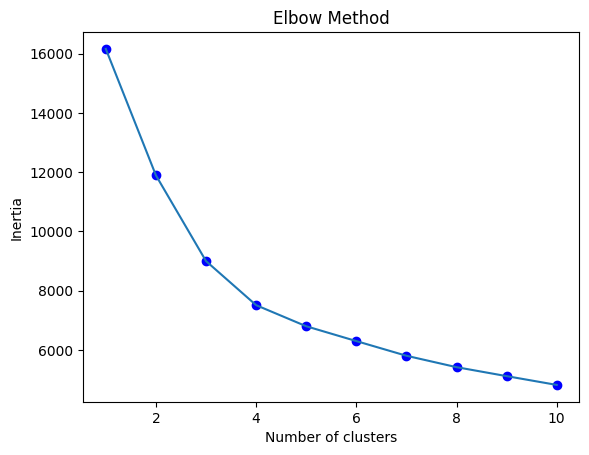

In [28]:
# Initialize an empty list to store the inertia values
inertia = []

# Define the range of clusters to test
k_range = range(1, 11)

# Loop through each value of k in the range and fit the model
for k in k_range:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(df_match_clustering)
    
    # Append the inertia value to the list
    inertia.append(model.inertia_)

    # Plot the k value and inertia value as a scatter point
    plt.scatter(k, model.inertia_, color='blue')

# Plot the elbow curve to find the optimal number of clusters
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [30]:
# Initialize the KMeans model with n_clusters=3
model = KMeans(n_clusters=3, random_state=notebook_seed, n_init='auto')

# Fit the model to the data
model.fit(df_match_clustering)

# Predict the cluster labels for each data point
labels = model.predict(df_match_clustering)

#### Cluster Visualization

In [32]:
# initialize the PCA object with the number of components you want to keep
pca = PCA(n_components=2)

# fit the PCA model to the data
pca.fit(df_match_clustering)

# transform the data into the new PCA space
transformed_data = pca.transform(df_match_clustering)

# create a new dataframe with the transformed data
df_pca = pd.DataFrame(transformed_data, columns=['PC1', 'PC2'])

pc1 = pca.explained_variance_ratio_[0]
pc2 = pca.explained_variance_ratio_[1]
print(f"PC1: {round(pc1 * 100, 2)}%")
print(f"PC2: {round(pc2 * 100, 2)}%")
print(f"Total Percent Explained: {round((pc1 + pc2) * 100, 2)}%")

PC1: 39.76%
PC2: 38.78%
Total Percent Explained: 78.54%


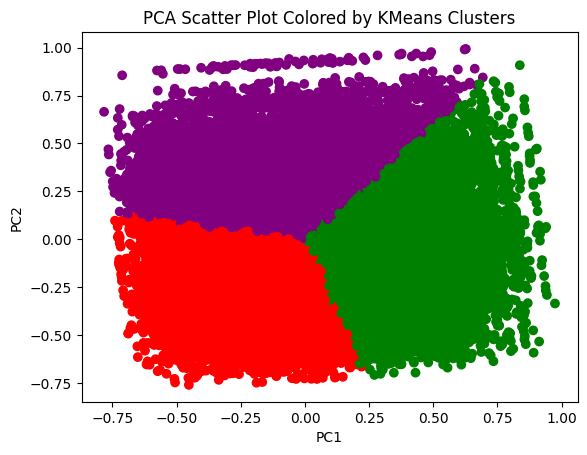

In [33]:
# define a list of colors, one for each cluster label
colors = ['Green', 'Red', 'Purple']

# map cluster labels to colors using the list of colors
color_labels = [colors[label] for label in labels]

# Plot clustering results
plt.scatter(df_pca.PC1, df_pca.PC2, c=color_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot Colored by KMeans Clusters')
plt.show()

In [34]:
# Save labels in df
df_train_match_clustering_analysis['labels_match'] = labels

# Group by label
cluster_statistics = df_train_match_clustering_analysis.groupby('labels_match').mean().reset_index()
cluster_statistics

,labels_match,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,winner_binary,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
0,0,4.723717,1453.019257,1454.706622,6.336260e+06,40.785691,0.446612,0.734286,8.390824,1601.947314,1600.901714,1.001385e+07,43.139523,0.680243,0.441749,0.177997,0.005165,0.363400,0.011690,0.852991,0.147009,0.442750,0.173713,0.004804,0.367043,0.011690,0.443190,0.172071,0.004844,0.368204,0.011690
1,1,3.758386,1404.390874,1407.113851,5.498934e+06,39.858447,0.375206,0.488582,3.734293,1401.919854,1406.161509,5.457164e+06,39.953924,0.370602,0.456054,0.188806,0.004827,0.338187,0.012127,0.904076,0.095924,0.457960,0.184466,0.004137,0.341310,0.012127,0.458041,0.188684,0.007950,0.333239,0.012087
2,2,8.440874,1601.102563,1599.821223,9.746229e+06,43.298906,0.678725,0.262057,4.649633,1453.270441,1455.866776,6.365450e+06,40.635061,0.447968,0.439277,0.176341,0.004990,0.367654,0.011737,0.852843,0.147157,0.436881,0.179974,0.005030,0.366217,0.011897,0.439676,0.182170,0.007865,0.358272,0.012017


In [35]:
# Assign meaningfull labels
cluster_names = {0: 'Neutral', 1: 'Fav_Away', 2: 'Fav_Home'}
cluster_statistics['labels_match'] = cluster_statistics['labels_match'].replace(cluster_names)
cluster_statistics

,labels_match,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,winner_binary,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X
0,Neutral,4.723717,1453.019257,1454.706622,6.336260e+06,40.785691,0.446612,0.734286,8.390824,1601.947314,1600.901714,1.001385e+07,43.139523,0.680243,0.441749,0.177997,0.005165,0.363400,0.011690,0.852991,0.147009,0.442750,0.173713,0.004804,0.367043,0.011690,0.443190,0.172071,0.004844,0.368204,0.011690
1,Fav_Away,3.758386,1404.390874,1407.113851,5.498934e+06,39.858447,0.375206,0.488582,3.734293,1401.919854,1406.161509,5.457164e+06,39.953924,0.370602,0.456054,0.188806,0.004827,0.338187,0.012127,0.904076,0.095924,0.457960,0.184466,0.004137,0.341310,0.012127,0.458041,0.188684,0.007950,0.333239,0.012087
2,Fav_Home,8.440874,1601.102563,1599.821223,9.746229e+06,43.298906,0.678725,0.262057,4.649633,1453.270441,1455.866776,6.365450e+06,40.635061,0.447968,0.439277,0.176341,0.004990,0.367654,0.011737,0.852843,0.147157,0.436881,0.179974,0.005030,0.366217,0.011897,0.439676,0.182170,0.007865,0.358272,0.012017


In [36]:
cluster_statistics[['labels_match', 'best_streak', 'best_streak_other', 'elo', 'elo_other', 'winner_binary']].rename(columns={'best_streak_other': 'best_streak_away', 'elo_other': 'elo_away'})

,labels_match,best_streak,best_streak_away,elo,elo_away,winner_binary
0,Neutral,4.723717,8.390824,1453.019257,1601.947314,0.734286
1,Fav_Away,3.758386,3.734293,1404.390874,1401.919854,0.488582
2,Fav_Home,8.440874,4.649633,1601.102563,1453.270441,0.262057


In [37]:
# Save labels in dataframe
df_train['labels_match'] = labels
df_train['labels_match'] = df_train['labels_match'].replace(cluster_names)
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X,labels_match
0,0.298246,0.156891,0.154185,0.011125,0.535714,0.30,0.4000,0.306667,0.303254,0.012190,0.529412,0.39,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Fav_Away
1,0.289474,0.331378,0.333333,0.005550,0.226190,0.30,0.4125,0.497778,0.500000,0.013160,0.258824,0.57,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Neutral
2,0.289474,0.281525,0.283407,0.006545,0.285714,0.32,0.3625,0.302222,0.303254,0.014760,0.258824,0.30,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Fav_Away
3,0.368421,0.571848,0.581498,0.014413,0.321429,0.71,0.4625,0.499259,0.501479,0.016630,0.388235,0.62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Fav_Home
4,0.289474,0.322581,0.325991,0.012833,0.202381,0.28,0.4125,0.567407,0.569527,0.016263,0.341176,0.67,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Neutral


#### Predicting Match Cluster

In [38]:
# Split data into training and test sets
match_label_X_train, match_label_X_test, match_label_y_train, match_label_y_test = train_test_split(df_train.drop('labels_match', axis=1), df_train['labels_match'], 
                                                                                                    test_size=test_train_split_percentage, 
                                                                                                    random_state=notebook_seed)

# Select columns for xgboost
match_label_X_train = match_label_X_train[machine_learning_columns]
match_label_X_test = match_label_X_test[machine_learning_columns]

# Convert categorical labels to numerical labels
transform_match_label_y = {'Neutral': 0, 'Fav_Away': 1, 'Fav_Home': 2}
match_label_y_train = match_label_y_train.map(transform_match_label_y)
match_label_y_test = match_label_y_test.map(transform_match_label_y)

# Define model
match_label_xgb = xgb.XGBClassifier()

# define the parameter grid
params = {
    'objective': ['multi:softmax'], 
    'num_class': [3],
    'max_depth': [2],
    'learning_rate': [1],
    'n_estimators': [300]
}

# define the GridSearchCV object
match_label_grid_search = GridSearchCV(
    estimator=match_label_xgb, 
    param_grid=params, 
    cv=3, 
#     scoring='accuracy',
    n_jobs=-1
)

# fit the GridSearchCV object to the training data
match_label_grid_search.fit(match_label_X_train, match_label_y_train)

# Print model fit
print("[INFO] -- Match Label Model Fit")

[INFO] -- Match Label Model Fit


In [39]:
# print the best hyperparameters, their corresponding scores, and the test results
print("Best parameters found: ", match_label_grid_search.best_params_)
print("Best score: ", match_label_grid_search.best_score_)

# Get test accuracy
best_match_label_model = match_label_grid_search.best_estimator_
match_label_y_pred = best_match_label_model.predict(match_label_X_test)
match_label_test_accuracy = np.mean(match_label_y_pred == match_label_y_test)

print("Test accuracy: ", match_label_test_accuracy)

Best parameters found:  {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 300, 'num_class': 3, 'objective': 'multi:softmax'}
Best score:  0.9921331026283552
Test accuracy:  0.9934391109325835


### Fighter Clustering

#### Get all fighters dataframe

In [40]:
# Home fighter
df_home_fighter = df_all_fighter_clustering[[
    'id',
    'best_streak',
    'elo',
#     'tier_A',
#     'tier_B',
#     'tier_P',
#     'tier_S',
#     'tier_X',
#     'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
]]

# Away fighter
df_away_fighter = df_all_fighter_clustering[[
    'id_other',
    'best_streak_other',
    'elo_other',
#     'tier_other_A',
#     'tier_other_B',
#     'tier_other_P',
#     'tier_other_S',
#     'tier_other_X',
#     'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
]]

# Rename Away Fighter Columns
rename_away_fighter_df_columns = {
    'id_other': 'id',
    'best_streak_other': 'best_streak',
    'elo_other': 'elo',
    'tier_other_A': 'tier_A',
    'tier_other_B': 'tier_B',
    'tier_other_P': 'tier_P',
    'tier_other_S': 'tier_S',
    'tier_other_X': 'tier_X',
    'tier_elo_other': 'tier_elo',
    'average_bet_other': 'average_bet',
    'total_matches_other': 'total_matches',
    'win_rate_other': 'win_rate'
}
df_away_fighter.rename(columns=rename_away_fighter_df_columns, inplace=True)

In [41]:
# Get unique home fighters
df_home_fighter = df_home_fighter.drop_duplicates(subset = ["id"])

df_away_fighter = df_away_fighter.drop_duplicates(subset = ["id"])
df_away_fighter['id'] = df_away_fighter['id'].astype('int')

In [42]:
# Get df_all_fighters
df_all_fighters = pd.concat([df_home_fighter, df_away_fighter], ignore_index=True).drop_duplicates(subset = ["id"])

# Copy df for cluster analysis
df_all_fighters_cluster_analysis = df_all_fighters.copy()

# Drop id column
df_all_fighters.drop(columns=['id'], inplace=True)
df_all_fighters.head()

,best_streak,elo,average_bet,total_matches,win_rate
0,5.0,1560.0,10870713.45,44.0,0.61
1,6.0,1616.0,11638689.78,65.0,0.60
2,5.0,1463.0,7753108.92,39.0,0.56
3,6.0,1570.0,9711342.29,35.0,0.66
4,4.0,1505.0,6581680.00,39.0,0.54


In [43]:
# fit the scaler on the fighter data
scaler_fighters = MinMaxScaler()
scaler_fighters.fit(df_all_fighters)

# Transform fighter data
df_all_fighters = pd.DataFrame(scaler_fighters.transform(df_all_fighters), columns=df_all_fighters.columns)

# View df
df_all_fighters.head()

,best_streak,elo,average_bet,total_matches,win_rate
0,0.309735,0.549630,0.020653,0.511905,0.61
1,0.318584,0.632593,0.022150,0.761905,0.60
2,0.309735,0.405926,0.014579,0.452381,0.56
3,0.318584,0.564444,0.018395,0.404762,0.66
4,0.300885,0.468148,0.012297,0.452381,0.54


#### K-Means Clustering

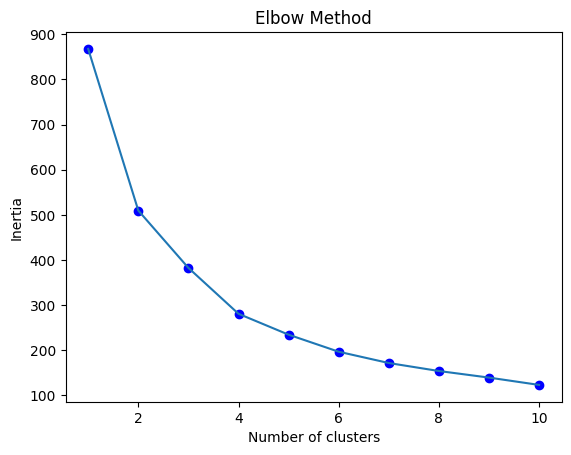

In [44]:
# Initialize an empty list to store the inertia values
inertia = []

# Define the range of clusters to test
k_range = range(1, 11)

# Loop through each value of k in the range and fit the model
for k in k_range:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(df_all_fighters)
    
    # Append the inertia value to the list
    inertia.append(model.inertia_)

    # Plot the k value and inertia value as a scatter point
    plt.scatter(k, model.inertia_, color='blue')

# Plot the elbow curve to find the optimal number of clusters
plt.plot(k_range, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [45]:
# Initialize the KMeans model with n_clusters=3
kmeans_fighters_model = KMeans(n_clusters=4, random_state=notebook_seed)

# Fit the model to the data
kmeans_fighters_model.fit(df_all_fighters)

# Predict the cluster labels for each data point
labels_fighters = kmeans_fighters_model.predict(df_all_fighters)

c:\Users\Sam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Cluster Visualization

In [46]:
# initialize the PCA object with the number of components you want to keep
pca_fighters = PCA(n_components=2)

# fit the PCA model to the data
pca_fighters.fit(df_all_fighters)

# transform the data into the new PCA space
transformed_data_fighters = pca_fighters.transform(df_all_fighters)

# create a new dataframe with the transformed data
df_pca_fighters = pd.DataFrame(transformed_data_fighters, columns=['PC1', 'PC2'])

pc1_fighters = pca_fighters.explained_variance_ratio_[0]
pc2_fighters = pca_fighters.explained_variance_ratio_[1]
print(f"PC1: {round(pc1_fighters * 100, 2)}%")
print(f"PC2: {round(pc2_fighters * 100, 2)}%")
print(f"Total Percent Explained: {round((pc1_fighters + pc2_fighters) * 100, 2)}%")

PC1: 60.04%
PC2: 34.38%
Total Percent Explained: 94.42%


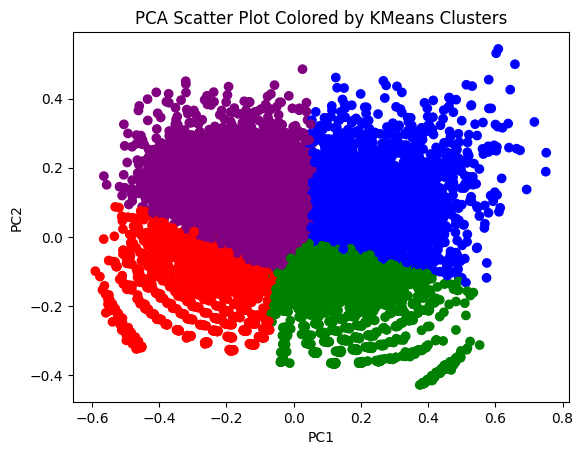

In [47]:
# define a list of colors, one for each cluster label
colors = [
    'Green', 
    'Purple',
    'Blue',
    'Red'
]

# map cluster labels to colors using the list of colors
color_labels = [colors[label] for label in labels_fighters]

# Plot clustering results
plt.scatter(df_pca_fighters.PC1, df_pca_fighters.PC2, c=color_labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot Colored by KMeans Clusters')
plt.show()

In [48]:
# Save labels in df
df_all_fighters_cluster_analysis['labels_fighters'] = labels_fighters

# Group by label
cluster_statistics_fighters = df_all_fighters_cluster_analysis.drop(columns=['id']).groupby('labels_fighters').mean().reset_index()
cluster_statistics_fighters

,labels_fighters,best_streak,elo,average_bet,total_matches,win_rate
0,0,5.324782,1540.878275,9.679325e+06,16.330240,0.668150
1,1,3.802627,1403.516765,5.470626e+06,41.124093,0.377615
2,2,8.042050,1587.491459,9.350178e+06,44.640385,0.656264
3,3,1.321965,1413.555252,4.484925e+06,14.958390,0.239741


In [49]:
# Assign meaningfull labels
cluster_names_fighters = { # Two fighter clusters
    0: 'Bad', 
    1: 'Good'
}

cluster_names_fighters = { # Four fighter clusters
    0: 'Ok', 
    1: 'Excellent',
    2: 'Good',
    3: 'Poor'
}

cluster_statistics_fighters['labels_fighters'] = cluster_statistics_fighters['labels_fighters'].replace(cluster_names_fighters)
cluster_statistics_fighters

,labels_fighters,best_streak,elo,average_bet,total_matches,win_rate
0,Ok,5.324782,1540.878275,9.679325e+06,16.330240,0.668150
1,Excellent,3.802627,1403.516765,5.470626e+06,41.124093,0.377615
2,Good,8.042050,1587.491459,9.350178e+06,44.640385,0.656264
3,Poor,1.321965,1413.555252,4.484925e+06,14.958390,0.239741


In [50]:
# Save labels in dataframe
df_all_fighters['labels_fighter'] = labels_fighters
df_all_fighters['labels_fighter'] = df_all_fighters['labels_fighter'].replace(cluster_names_fighters)
df_all_fighters.head()

,best_streak,elo,average_bet,total_matches,win_rate,labels_fighter
0,0.309735,0.549630,0.020653,0.511905,0.61,Good
1,0.318584,0.632593,0.022150,0.761905,0.60,Good
2,0.309735,0.405926,0.014579,0.452381,0.56,Excellent
3,0.318584,0.564444,0.018395,0.404762,0.66,Good
4,0.300885,0.468148,0.012297,0.452381,0.54,Good


#### Predicting Fighter Cluster

In [51]:
# Split data into training and test sets
fighter_label_X_train, fighter_label_X_test, fighter_label_y_train, fighter_label_y_test = train_test_split(df_all_fighters.drop('labels_fighter', axis=1), df_all_fighters['labels_fighter'], 
                                                                                                    test_size=test_train_split_percentage, 
                                                                                                    random_state=notebook_seed)

# Choose columns
columns_fighter_label_prediction = [
    'best_streak',
    'elo',
    'average_bet',
    'total_matches',
    'win_rate'
]

# Select columns for xgboost
fighter_label_X_train = fighter_label_X_train[columns_fighter_label_prediction]
fighter_label_X_test = fighter_label_X_test[columns_fighter_label_prediction]

# Convert categorical labels to numerical labels
# transform_fighter_label_y = {'Bad': 0, 'Good': 1} # Two clusters
transform_fighter_label_y = { # Four fighter clusters
    'Ok': 0, 
    'Excellent': 1,
    'Good': 2,
    'Poor': 3
}

fighter_label_y_train = fighter_label_y_train.map(transform_fighter_label_y)
fighter_label_y_test = fighter_label_y_test.map(transform_fighter_label_y)

# Define model
fighter_label_xgb = xgb.XGBClassifier()

# define the parameter grid
params_fighter_label = {
    'max_depth': [5],
    'learning_rate': [0.1],
    'n_estimators': [300]
}

# define the GridSearchCV object
fighter_label_grid_search = GridSearchCV(
    estimator=fighter_label_xgb, 
    param_grid=params_fighter_label, 
    cv=10, 
    scoring='roc_auc',
    n_jobs=-1
)

# fit the GridSearchCV object to the training data
fighter_label_grid_search.fit(fighter_label_X_train, fighter_label_y_train)

# Print model fit
print("[INFO] -- Fighter Label Model Fit")

c:\Users\Sam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


[INFO] -- Fighter Label Model Fit


In [53]:
# print the best hyperparameters, their corresponding scores, and the test results
print("Best parameters found: ", fighter_label_grid_search.best_params_)
print("Best score: ", fighter_label_grid_search.best_score_)

# Get test accuracy
best_fighter_label_model = fighter_label_grid_search.best_estimator_
match_fighter_y_pred = best_fighter_label_model.predict(fighter_label_X_test)
fighter_label_test_accuracy = np.mean(match_fighter_y_pred == fighter_label_y_test)

print("Test accuracy: ", fighter_label_test_accuracy)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score:  nan
Test accuracy:  0.9946902654867257


### Adding Cluster Labels

#### Match labels

In [54]:
# Adding match labels to test and val
df_test['labels_match'] = best_match_label_model.predict(df_test[machine_learning_columns])
df_val['labels_match'] = best_match_label_model.predict(df_val[machine_learning_columns])
df_test['labels_match'] = df_test['labels_match'].map(cluster_names)
df_val['labels_match'] = df_val['labels_match'].map(cluster_names)

# Apply one-hot encoding to the selected columns
df_train = pd.get_dummies(df_train, columns=['labels_match'])
df_val = pd.get_dummies(df_val, columns=['labels_match'])
df_test = pd.get_dummies(df_test, columns=['labels_match'])

#### Fighter labels

In [55]:
# Adding fighter labels
# TODO: Implement fighter cluster prediction
# todo = best_fighter_label_model.predict(df_test[fighter_clustering_columns])

# Merge fighter labels into training DataFrame
df_train[['id', 'id_other']] = df_train_ids.sort_index(ascending=True).reset_index(drop=True)

# Add fighter id's for merge
df_all_fighters['id'] = df_all_fighters_cluster_analysis['id']

# Merge fighter labels with df_train
df_train = pd.merge(df_train, df_all_fighters[['id', 'labels_fighter']], on='id', how='left')
df_train.drop(columns=['id', 'id_other'], inplace=True)

# Merge fighter labels with df_test
df_test[['id', 'id_other']] = df_test_ids.sort_index(ascending=True).reset_index(drop=True)
df_test = pd.merge(df_test, df_all_fighters[['id', 'labels_fighter']], on='id', how='left')
df_test.drop(columns=['id', 'id_other'], inplace=True)

# Merge fighter labels with df_val
df_val[['id', 'id_other']] = df_val_ids.sort_index(ascending=True).reset_index(drop=True)
df_val = pd.merge(df_val, df_all_fighters[['id', 'labels_fighter']], on='id', how='left')
df_val.drop(columns=['id', 'id_other'], inplace=True)

# Apply one-hot encoding to the selected columns
df_train = pd.get_dummies(df_train, columns=['labels_fighter'])
df_val = pd.get_dummies(df_val, columns=['labels_fighter'])
df_test = pd.get_dummies(df_test, columns=['labels_fighter'])

# Model Fitting

In [1]:
# Hello
print("Hello World")

Hello World


#### XGBoost

In [56]:
df_train.head()

,best_streak,elo,tier_elo,average_bet,total_matches,win_rate,best_streak_other,elo_other,tier_elo_other,average_bet_other,total_matches_other,win_rate_other,tier_A,tier_B,tier_P,tier_S,tier_X,match_format_matchmaking,match_format_tournament,match_tier_A,match_tier_B,match_tier_P,match_tier_S,match_tier_X,tier_other_A,tier_other_B,tier_other_P,tier_other_S,tier_other_X,labels_match_Fav_Away,labels_match_Fav_Home,labels_match_Neutral,labels_fighter_Excellent,labels_fighter_Good,labels_fighter_Ok,labels_fighter_Poor
0,0.298246,0.156891,0.154185,0.011125,0.535714,0.30,0.4000,0.306667,0.303254,0.012190,0.529412,0.39,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,1,0,0
1,0.289474,0.331378,0.333333,0.005550,0.226190,0.30,0.4125,0.497778,0.500000,0.013160,0.258824,0.57,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1,0,0
2,0.289474,0.281525,0.283407,0.006545,0.285714,0.32,0.3625,0.302222,0.303254,0.014760,0.258824,0.30,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1,0,0
3,0.368421,0.571848,0.581498,0.014413,0.321429,0.71,0.4625,0.499259,0.501479,0.016630,0.388235,0.62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,1,0,0
4,0.289474,0.322581,0.325991,0.012833,0.202381,0.28,0.4125,0.567407,0.569527,0.016263,0.341176,0.67,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1,0,0


In [67]:
xgb_columns = [
    # Home fighter
    'best_streak',
    'elo',
    'tier_A',
    'tier_B',
    'tier_P',
    'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
    'tier_other_A',
    'tier_other_B',
    'tier_other_P',
    'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
    'match_format_tournament',
    'match_tier_A',
    'match_tier_B',
    'match_tier_P',
    'match_tier_S',
#     'match_tier_X', # Most common category
    
    # Cluster labels
    
    # Match labels
    'labels_match_Fav_Away',
    'labels_match_Fav_Home',
#     'labels_match_Neutral', # Most boring
    
    # Fighter labels 
    # Two clusters
#     'labels_fighter_Bad', # Most common category
#     'labels_fighter_Good',
    # Four clusters
    'labels_fighter_Excellent',
    'labels_fighter_Good',
    'labels_fighter_Ok',
#     'labels_fighter_Poor' # Most common category
]

xgb_train = df_train[xgb_columns]
xgb_val = df_val[xgb_columns]
xgb_test = df_test[xgb_columns]

# Use cluster labels
cluster_columns = [
    # Match labels
    'labels_match_Fav_Away',
    'labels_match_Fav_Home',
#     'labels_match_Neutral', # Most boring
    
    # Fighter labels 
    # Two clusters
#     'labels_fighter_Bad', # Most common category
#     'labels_fighter_Good',
    # Four clusters
    'labels_fighter_Excellent',
    'labels_fighter_Good',
    'labels_fighter_Ok',
#     'labels_fighter_Poor'
]

# xgb_train = df_train[cluster_columns] # Uncomment to use only cluster labels as features
# xgb_val = df_val[cluster_columns] # Uncomment to use only cluster labels as features
# xgb_test = df_test[cluster_columns] # Uncomment to use only cluster labels as features

# Try PCA
n_components=4
pca_try = PCA(n_components=n_components)
pca_try.fit(xgb_train)

# transform the data into the new PCA space
pca_train = pca_try.transform(xgb_train)
pca_val = pca_try.transform(xgb_val)
pca_test = pca_try.transform(xgb_test)

pca_train = pd.DataFrame(pca_train, columns=['PC'+str(i) for i in range(1, n_components+1)])
pca_val = pd.DataFrame(pca_val, columns=['PC'+str(i) for i in range(1, n_components+1)])
pca_test = pd.DataFrame(pca_test, columns=['PC'+str(i) for i in range(1, n_components+1)])

# xgb_train = pca_train # Uncomment to use only PC's as features
# xgb_val = pca_val # Uncomment to use only PC's as features
# xgb_test = pca_test # Uncomment to use only PC's as features

In [68]:
print("VIF of features:")
for idx, col in enumerate(list(xgb_train.columns)):
    vif = variance_inflation_factor(xgb_train, idx)
    print(f" - {col}: {vif}")

VIF of features:
 - best_streak: 139.96309651248959
 - elo: 663.3091474779238
 - tier_A: 8434.702731032272
 - tier_B: 3488.6886800046223
 - tier_P: 108.98114095627722
 - tier_S: 6703.743252512956
 - tier_elo: 559.9820803009062
 - average_bet: 3.0102714133310347
 - total_matches: 34.38736308260482
 - win_rate: 101.97209596859055
 - best_streak_other: 127.67318161770818
 - elo_other: 565.8545155315762
 - tier_other_A: 8445.28851070814
 - tier_other_B: 3488.299241643459
 - tier_other_P: 138.96459201348867
 - tier_other_S: 6611.752720211232
 - tier_elo_other: 480.62324307193546
 - average_bet_other: 3.2692865471913017
 - total_matches_other: 33.499872760354
 - win_rate_other: 100.2908020223803
 - match_format_tournament: 1.202652186646829
 - match_tier_A: 16789.75397846944
 - match_tier_B: 6879.029518397169
 - match_tier_P: 195.32638616114778
 - match_tier_S: 13385.633999809605
 - labels_match_Fav_Away: 4.187264242684735
 - labels_match_Fav_Home: 4.858397682932037
 - labels_fighter_Excelle

In [61]:
# define the parameter grid
params = {'max_depth': [2, 3, 4],
          'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [200, 300, 400]}

# create an XGBoost classifier
clf = xgb.XGBClassifier()

# perform grid search using GridSearchCV
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=params, 
                           cv=3, 
                           scoring='roc_auc',
#                            scoring='accuracy',
                           n_jobs=-1
                          )
grid_search.fit(xgb_train, y_train)
print(f"[INFO] -- Fit model")

[INFO] -- Fit model


In [65]:
# print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best CV accuracy:', grid_search.best_score_)

# make predictions on the test data using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(xgb_test)
y_pred_probs = best_model.predict_proba(xgb_test)
accuracy = np.mean(y_pred == y_test)
print('Test accuracy:', accuracy)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
Best CV accuracy: 0.793702700788718
Test accuracy: 0.7179706915759705


# CNN

In [ ]:
cnn_columns = [
    # Home fighter
    'best_streak',
    'elo',
    'tier_A',
    'tier_B',
    'tier_P',
    'tier_S',
#     'tier_X', # Most common category
    'tier_elo',
    'average_bet',
    'total_matches',
    'win_rate',
    
    # Away fighter
    'best_streak_other',
    'elo_other',
    'tier_other_A',
    'tier_other_B',
    'tier_other_P',
    'tier_other_S',
#     'tier_other_X', # Most common category
    'tier_elo_other',
    'average_bet_other',
    'total_matches_other',
    'win_rate_other',
    
    # Match information
#     'match_format_matchmaking', # Most common category
    'match_format_tournament',
    'match_tier_A',
    'match_tier_B',
    'match_tier_P',
    'match_tier_S',
#     'match_tier_X', # Most common category
]

cnn_train = df_train[cnn_columns]
cnn_val = df_val[cnn_columns]
cnn_test = df_test[cnn_columns]

In [ ]:
# # Define the model architecture
# model = Sequential()
# input_shape = cnn_train.shape[1:]
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Fit the model to the training data
# model.fit(cnn_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(cnn_val, y_val))

# Make Predictions

#### Match data preparation functions

In [69]:
# Get data for the current match
def get_current_match_data():    
    # store the response of URL
    response_match = urlopen(match_url)

    # storing the JSON response from url in data
    match_data_json = json.loads(response_match.read())

    # Define columns
    columns_match_data = {
        'best_streak': 'best_streak', # 0
        'elo': 'elo', # 1
        'tier': 'tier', # 2
        'tier_elo': 'tier_elo', # 3
        'average_bet': 'average_bet', # 4
        'total_matches': 'total_matches', # 5
        'win_rate': 'win_rate', # 6
        'match_format': 'match_format', # 7
        'match_tier': 'tier', # 8
        'best_streak_other': 'best_streak', # 9
        'elo_other': 'elo', # 10
        'tier_other': 'tier', # 11
        'tier_elo_other': 'tier_elo', # 12
        'average_bet_other': 'average_bet', # 13
        'total_matches_other': 'total_matches', # 14
        'win_rate_other': 'win_rate', # 15
    }

    data_extraction_match = list(columns_match_data.values())

    # Init match_data
    match_data = pd.DataFrame(columns = columns_match_data)

    # Define lists for data extraction
    sides = ['fighter_blue_info', 'fighter_red_info']

    temp_data = [
        match_data_json['fighter_blue_info'][data_extraction_match[0]],
        match_data_json['fighter_blue_info'][data_extraction_match[1]],
        match_data_json['fighter_blue_info'][data_extraction_match[2]],
        match_data_json['fighter_blue_info'][data_extraction_match[3]],
        match_data_json['fighter_blue_info']['stats'][data_extraction_match[4]],
        match_data_json['fighter_blue_info']['stats'][data_extraction_match[5]],
        match_data_json['fighter_blue_info']['stats'][data_extraction_match[6]],
        match_data_json[data_extraction_match[7]],
        match_data_json[data_extraction_match[8]],
        match_data_json['fighter_red_info'][data_extraction_match[9]],
        match_data_json['fighter_red_info'][data_extraction_match[10]],
        match_data_json['fighter_red_info'][data_extraction_match[11]],
        match_data_json['fighter_red_info'][data_extraction_match[12]],
        match_data_json['fighter_red_info']['stats'][data_extraction_match[13]],
        match_data_json['fighter_red_info']['stats'][data_extraction_match[14]],
        match_data_json['fighter_red_info']['stats'][data_extraction_match[15]],
    ]

    return pd.concat([match_data, pd.DataFrame([temp_data], columns = list(columns_match_data.keys()))])

# process encode columns
def process_current_data(df):
    # Blue fighter data
    df['tier_A'] = 0
    df['tier_B'] = 0
    df['tier_P'] = 0
    df['tier_S'] = 0
    
    # Red fighter data
    df['tier_other_A'] = 0
    df['tier_other_B'] = 0
    df['tier_other_P'] = 0
    df['tier_other_S'] = 0
    
    # Match data
    df['match_format_tournament'] = 0
    df['match_tier_A'] = 0
    df['match_tier_B'] = 0
    df['match_tier_P'] = 0
    df['match_tier_S'] = 0
    
    # Add to make scaling easier
    df['winner_binary'] = 0
    
    # Set correct dummy variables
    if df.tier[0] != 'X':
        df[f"tier_{df.tier[0]}"] = 1
    if df.tier_other[0] != 'X':
        df[f"tier_other_{df.tier_other[0]}"] = 1
    if df.match_format[0] != 'matchmaking':
        df[f"match_format_{df.match_format[0]}"] = 1
    if df.match_tier[0] != 'X':
        df[f"match_tier_{df.match_tier[0]}"] = 1
        
    return df

#### Make current match prediction

In [ ]:
while True:  
    try:
        while True:
            time.sleep(12)
            print('.')
            time.sleep(1)
            print('.')
            time.sleep(1)

            processed_current_match_data = process_current_data(get_current_match_data())[df_all.columns]
            std_current_match_data = pd.DataFrame(scaler.transform(processed_current_match_data), columns=df_all.columns)
            prediction = best_model.predict(std_current_match_data[xgb_columns])[0]
            probability = best_model.predict_proba(std_current_match_data[xgb_columns])[0]

            threashhold = max(probability)
            returns_calc = []
            for idx, probs in enumerate(y_pred_probs):
                home_prob = probs[0]
                away_prob = probs[1]
                ground_truth = y_test[idx]

                if (home_prob >= threashhold) and (ground_truth == 0):
                    returns_calc.append(1)
                elif (home_prob >= threashhold) and (ground_truth == 1):
                    returns_calc.append(0)
                elif (away_prob >= threashhold) and (ground_truth == 1):
                    returns_calc.append(1)
                elif (away_prob >= threashhold) and (ground_truth == 0):
                    returns_calc.append(0)

            chance_correct = float(np.mean(returns_calc))*100

            clear_output(wait=True)

            if prediction == 0:
                print(f"[INFO] -- Prediction: Blue")
                print(f"[INFO] -- Probability: {round(float(probability[0]*100), 3)}%")
                print(f"[INFO] -- Chance correct: {chance_correct}%")
            elif prediction == 1:
                print(f"[INFO] -- Prediction: Red")
                print(f"[INFO] -- Probability: {round(float(probability[1]*100), 3)}%")
                print(f"[INFO] -- Chance correct: {chance_correct}%")

            if threashhold > 0.9:
                mixer.music.play()
                time.sleep(15)
    except:
        time.sleep(5)

#### General Betting Rules of Thumb

"Probability" Threashholds:
- 50%-90%: 0
- 90%-95%: 5000
- 95%- on: Judgement
- 100%: All In YYYEEEEEHAWWWWWWW

# Calculating Returns

In [ ]:
# split the dataframe into training, validation, and testing sets
df_train_calculations, df_test_calculations = train_test_split(df, test_size=test_train_split_percentage, 
                                                               random_state=notebook_seed)
df_train_calculations, df_val_calculations = train_test_split(df_train_calculations, test_size=train_validation_split_percentage, 
                                                              random_state=notebook_seed)

# Notes

- Interacting through a twitch channel requires registering your bot with twitch first, getting an Oauth token (personalized)...

- then connecting to the twitch IRC, sending keepalive messages, and then sending your message when you'd like..

- BUT you're looking to interact with saltybet's website itself...which my bot also does....and that requires beautifulsoup for python

- but yeah, it was just beautiful soup to parse the info from the SB website. To actually interact with it and place bets, all I needed was the "socket" module. Connect to the IRC thru the socket with your creds, then post messages through the socket. All in 1 module.

- socket.recv (to read twitch chat), and socket.send (to send messages(must be in proper format))